# Air Liquide Code Challenge -  Movie Recommendation

## Collaborative Filtering

We investigate two algorithms for collaborative filtering

- Item-based neighborhood methods
- Matrix factorization

The following notebook is implemented in colab, thus there are some configurations specific to colab.

## 1. Preliminaries


### Package Imports

In [222]:
import os
import itertools
import collections
from collections import defaultdict
from operator import itemgetter


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten
from tensorflow.keras.models import Model
print(tf.__version__)


from sklearn.metrics.pairwise import cosine_similarity

%matplotlib inline

seed=1234
np.random.seed(seed)

2.3.0


In [182]:
# This configuration is required by some GPUs and not others, assuming only one gpu
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if  len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    assert tf.config.experimental.get_memory_growth(physical_devices[0]) == True

## 2. Data Preprocessing

In [2]:
!wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip -o ml-latest-small.zip

--2020-11-05 21:33:52--  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  3.32MB/s    in 0.3s    

2020-11-05 21:33:52 (3.32 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


In [60]:
location='ml-latest-small/'
data_ratings=pd.read_csv(location+'ratings.csv')
data_movies=pd.read_csv(location+'movies.csv')
data_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [61]:
#check the data integrity
data_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


Text(0.5, 1.0, 'Rating distribution')

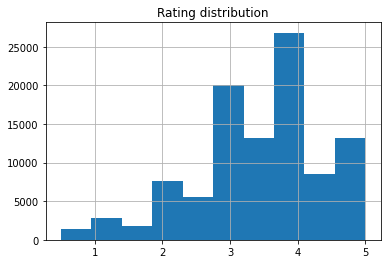

In [179]:
#check the distribution of the rating data
data_ratings['rating'].hist()
plt.title('Rating distribution')

### Train Test Split

Here we do not handle carefuly new users or new movies (we just asign them at random).

In [65]:
#shuffle the data
data_ratings=data_ratings.sample(frac=1)


#encoder to continuous range
userEncoder=LabelEncoder()
movieEncoder=LabelEncoder()

users_all=userEncoder.fit_transform(data_ratings[["userId"]].values.ravel())
movies_all=movieEncoder.fit_transform(data_ratings[["movieId"]].values.ravel())
ratings_all=data_ratings[["rating"]].values.ravel()

#unique users and movies
unique_users=userEncoder.classes_
unique_movies=movieEncoder.classes_

N_users=len(unique_users)
N_movies=len(unique_movies)
print(N_users,N_movies)

610 9724


In [326]:
users, users_test, movies, movies_test, ratings, ratings_test=train_test_split(users_all,movies_all,ratings_all,test_size=0.15) #split test set
users_train, users_val, movies_train, movies_val, ratings_train,ratings_val=train_test_split(users,movies,ratings,test_size=0.15) #split train and validation set

print(f"train size {users_train.shape[0]}, validation size {users_val.shape[0]}, test size {users_test.shape[0]}")

train size 72853, validation size 12857, test size 15126


In [327]:
#sanity check
unknown_users=~np.isin(users_val, users)
unknown_movies=~np.isin(movies_val, movies)
print(unknown_users.sum(), unknown_movies.sum())

0 0


## 3. Item-based Neighborhood Model

For item-based neighborhood model, the target is to build an item-item matrix determining relationships between pairs of items. Here we infer the tastes of the current user by examining the matrix and matching that user's data. We use cosine similarity to measure the difference between two items (movies).

### Model Implementation

In [260]:
class ItemBasedCF:
    """
    Item-based Collaborative filtering.
    Top-N recommendation.
    """

    def __init__(self, k_similar_movie=20, n_rec_movie=10):
        """
        Init UserBasedCF with k_sim_item and n_rec_item.
        """
        print("Start Item-based Collaborative filtering ...\n")
        self.k_similar_item = k_similar_movie
        self.n_rec_item = n_rec_movie
        self.trainset = None
    
    def calculate_item_popular(self, data):
        """
        Counting movies number and popularity
        """
        movie_popular = defaultdict(int)
        for user, movies in data.items():
            for movie in movies:
                # count item popularity
                movie_popular[movie] += 1
        
        # save the total movie number, which will be used in evaluation
        movie_count = len(movie_popular)
        return movie_popular, movie_count



    def calculate_item_similarity(self, data):
        """
        Calculate the item cosine similarity matrix using the movie-users inverse table
        The calculating will only between items which are voted by common users
        """

        movie_popular, movie_count = self.calculate_item_popular(data)

        # count co-rated items between users
        print('generate items co-rated similarity matrix...')
        # set item_sim_matrix as a two-dim table: [movie_id1][co-existing_movie_is2]
        
        item_similar_matrix = {}
        for user, movies in data.items():
            for movie1, movie2 in list(itertools.combinations(movies, 2)):
                item_similar_matrix.setdefault(movie1, defaultdict(int))
                item_similar_matrix.setdefault(movie2, defaultdict(int))
                item_similar_matrix[movie1][movie2] += 1
                item_similar_matrix[movie2][movie1] += 1 
        
        # calculate item-item similarity matrix
        print('calculate item-item similarity matrix...')
        # record the calculate time has spent.
        
        for movie1, related_items in item_similar_matrix.items():
            len_user1 = movie_popular[movie1]
            for movie2, count in related_items.items():
                len_user2 = movie_popular[movie2]
                # The similarity of user1 and user2 is len(common movies)/sqrt(len(user1 movies)* len(user2 movies)
                item_similar_matrix[movie1][movie2] = count / np.sqrt(len_user1 * len_user2)

        
        return item_similar_matrix, movie_popular, movie_count

    def fit(self, data):
        """
        Fit the train data by calculate movie similarity matrix.
        """
    
        self.item_similar_matix, self.movie_popular, self.movie_count = self.calculate_item_similarity(data)
        self.trainset = data
        print('Model training finished')
        

    def recommend(self, user):
        """
        Find K similar movies and recommend N movies for the user
        """
        if not self.item_similar_matix or not self.n_rec_item or not self.trainset or not self.movie_popular or not self.movie_count:
            raise NotImplementedError('ItemCF has not init or fit method has not called yet.')
        K = self.k_similar_item
        N = self.n_rec_item
        predict_score = collections.defaultdict(int)

        rated_movies = self.trainset[user]
        for movie, rating in rated_movies.items():

            if movie not in self.item_similar_matix:
                print("Error: non-existing movie")
                return -1
            for related_movie, similarity_factor in sorted(self.item_similar_matix[movie].items(), key=itemgetter(1), reverse=True)[0:K]:
                if related_movie in rated_movies:
                    continue
                predict_score[related_movie] += similarity_factor * rating
                

        return [movie for movie, _ in sorted(predict_score.items(), key=itemgetter(1), reverse=True)[0:N]]

    def test(self, testset):
        """
        Test the recommendation system by recommending scores to all users in testset.
        """
        if not self.n_rec_item or not self.trainset or not self.movie_popular or not self.movie_count:
            raise ValueError('ItemCF has not init or fit method has not called yet.')
        self.testset = testset
        N = self.n_rec_item
        
        #  varables for precision and recall
        hit = 0
        rec_count = 0
        test_count = 0
        
        for i, user in enumerate(self.trainset):
            test_movies = self.testset.get(user, {})
            rec_movies = self.recommend(user)  # type:list
            hit += len(set(test_movies).intersection(rec_movies))
            
            rec_count += N
            test_count += len(test_movies)
            if i%100==0:
                print(f"Iteration {i} testing performance now....")
            
        precision = hit / (1.0 * rec_count)
        recall = hit / (1.0 * test_count)
        print(f'precision={precision}\t recall={recall}\n')

        return precision, recall

    def predict(self, testset):
        """
        Recommend movies to all users in testset
        """
        items_recommend = defaultdict(list)

        for i, user in enumerate(testset):
            rec_movies = self.recommend(user)  # type:list
            items_recommend[user].append(rec_movies)

        return items_recommend

### Model Training

In [206]:
#convert dataframe into dictionary for model training
train_dict, val_dict, test_dict = collections.defaultdict(dict), collections.defaultdict(dict), collections.defaultdict(dict)
for user, movie, rate in zip(users_train, movies_train, ratings_train):
    train_dict[user][movie]=int(rate)
for user, movie, rate in zip(users_val, movies_val, ratings_val):
    val_dict[user][movie]=int(rate)
for user, movie, rate in zip(users_test, movies_test, ratings_test):
    test_dict[user][movie]=int(rate)


In [261]:
ItemBasedCFModel = ItemBasedCF(20, 10)
ItemBasedCFModel.fit(train_dict)

Start Item-based Collaborative filtering ...

generate items co-rated similarity matrix...
calculate item-item similarity matrix...
Model training finished


### Model Performance and Prediction

In [254]:
#check the recommendation of a random user
idx=np.random.randint(0,len(users_all))
test_user=users_all[idx]
print(f"random user {test_user}")

movies=ItemBasedCFModel.recommend(test_user)
print(movies)

random user 507
[5486, 1351, 7668, 7617, 7873, 7999, 6687, 7457, 7210, 1518]


In [264]:
#evaluate the validation set performance
val_prec, val_recall = ItemBasedCFModel.test(val_dict)

Iteration 0 testing performance now....
Iteration 100 testing performance now....
Iteration 200 testing performance now....
Iteration 300 testing performance now....
Iteration 400 testing performance now....
Iteration 500 testing performance now....
Iteration 600 testing performance now....
precision=0.12672131147540983	 recall=0.06012289025433616



In [262]:
#evaluate the test set performance
test_prec, test_recall = ItemBasedCFModel.test(test_dict)

Iteration 0 testing performance now....
Iteration 100 testing performance now....
Iteration 200 testing performance now....
Iteration 300 testing performance now....
Iteration 400 testing performance now....
Iteration 500 testing performance now....
Iteration 600 testing performance now....
precision=0.15245901639344261	 recall=0.061483538278460925



## 4. Matrix Factorization Model - Using Keras

According to Wikipedia, we choose the SVD++ matrix factorzation model denoting the rating $r_{u,i}$ for user $u$ and movie $i$ as 
\begin{equation}
	\hat{r}_{i,u} =\mu + b_u + b_i + p_u^T q_i
\end{equation}

where the parameters are defined as follows:
- Mean rating: $\mu$ is the average rating of all users over all movies in our training
-User bias $b_u$ is a per user bias that will be higher for users that give high
average ratings to all movies
- Item bias $b_i$ is a per item (movie) bias that will be higher for the more popular (higher ranked) movies
- User embedding $p_u$ is the a per user F dimensional vector that maps user u into some kind of abstract taste space
- Item embedding $q_i$ is a per item F dimensional vector that maps item
i into the taste space

Our target is to train the interaction terms with embedding dimension $F$ s.t. $p_u$ has $U*F$ coefficients, $p_i$ has $I*F$ coefficients.


### Model Implementation using Keras

We will implement the matrix factoirzation model 
\begin{equation}
	\Delta \hat{r}_{i,u} =b_u + b_i + p_u^T q_i
\end{equation}

where $  \Delta \hat{r}_{i,u} = \hat{r}_{i,u} - \mu
$ using `keras` layers.

We define a callback helper function to show optimization progress every 10 epochs or so.

In [11]:
class ReportCallback(keras.callbacks.Callback):
    def __init__(self, frequency, use_val=False):
        self.freq=frequency
        self.use_val=use_val
        self.separator=" || "
        if not(self.use_val):
            self.separator="\n"
    def on_epoch_end(self, epoch, logs={}):
        if (epoch % self.freq ==0):
            train_loss=logs["loss"]
            train_error=logs["rmse"]
            print(f"{epoch}: TRAIN Loss {train_loss:.4f},  Err {train_error:.4f}", end=self.separator)
            if self.use_val:
                val_loss=logs["val_loss"]
                val_error=logs["val_rmse"]
                print(f"VAL Loss {val_loss:.4f}, Err {val_error:.4f}")

In [422]:
class ReportCallback(keras.callbacks.Callback):
    def __init__(self, frequency, use_val=False):
        self.freq=frequency
        self.use_val=use_val
        self.separator=" || "
        if not(self.use_val):
            self.separator="\n"
    def on_epoch_end(self, epoch, logs={}):
        if (epoch % self.freq ==0):
            train_loss=logs["loss"]
            train_error=logs["rmse"]
            print(f"{epoch}: TRAIN Loss {train_loss:.4f},  Err {train_error:.4f}", end=self.separator)
            if self.use_val:
                val_loss=logs["val_loss"]
                val_error=logs["val_rmse"]
                print(f"VAL Loss {val_loss:.4f}, Err {val_error:.4f}")


#define the collaborative filtering model
class MatrixFactorCF:
    def __init__(self, u_users, m_items, f_factors, penalty):
        """
        Init Matrix Factorization model
        """
        users=Input(shape=(1,))
        movies=Input(shape=(1,))
        bu=Embedding(u_users, 1, input_length=1,
                    embeddings_initializer=keras.initializers.RandomNormal(stddev=0.0001),)(users)
        bm=Embedding(m_items, 1, input_length=1,
                    embeddings_initializer=keras.initializers.RandomNormal(stddev=0.0001),)(movies)
        pu=Embedding(u_users, f_factors, input_length=1,
                    embeddings_initializer=keras.initializers.RandomNormal(stddev=1/np.sqrt(f_factors)),
                    embeddings_regularizer=keras.regularizers.l2(penalty),
                    name='UserEmbeddingLayer')(users) #add L2 regularization
        qm=Embedding(m_items, f_factors, input_length=1,
                    embeddings_initializer=keras.initializers.RandomNormal(stddev=1/np.sqrt(f_factors)),
                    embeddings_regularizer=keras.regularizers.l2(penalty),
                    name='MovieEmbeddingLayer')(movies)
        interaction=Dot(axes=-1)([pu,qm])
        agg=Add()([bu, bm, interaction])
        r_hat=Flatten()(agg)
        self.model=Model(inputs=[users,movies], outputs=r_hat)
        
    
    def rmse(self, y_true, y_pred):
        """
        define the metrics (keras by default will include the penalty on the metrics report)
        """
        return keras.backend.mean(keras.backend.square(y_pred-y_true),axis=-1)

    def compile(self, loss='mean_squared_error',verbose=True):
        """ Compile the model """
        self.model.compile(optimizer=keras.optimizers.Adam(), metrics=[rmse], loss=loss)
        if verbose:
            self.model.summary()

    def fit(self, users_train, movies_train, ratings_train, users_val=None, movies_val=None, ratings_val=None, 
            verbose=False, epochs=100, batch_size=500):
        """ Fit the model and train """
        mu=ratings_train.mean()
        #save the training paramters
        self.mu = mu
        self.movies_trainset = np.array(list(set(movies_train))).ravel()

        dratings_train = ratings_train-mu
        dratings_val = None
        if movies_val is not None:
            dratings_val = ratings_val-mu
        trainset = [users_train, movies_train]
        valset = [users_val, movies_val]
        history = self.model.fit(trainset, dratings_train, epochs=epochs, batch_size=batch_size, 
                       callbacks=[ReportCallback(10,True)], verbose=verbose,
                        validation_data=(valset, dratings_val))
        
        self.user_embedding = self.model.get_layer('UserEmbeddingLayer').output
        self.movie_embedding = self.model.get_layer('MovieEmbeddingLayer').output
        
        return history

    def predict(self, users_test, movies_test):
        """ Predict the rating for test data (user and movie)"""
        return self.mu+self.model.predict([users_test,movies_test]).ravel()
    
    def recommend(self, user, N_rec=10):
        """Recommend movie for users"""
        n_movies = len(self.movies_trainset)
        predictions = model.predict(np.array([user]*n_movies).ravel(), self.movies_trainset)
        rec_movies = sorted(zip(self.movies_trainset,predictions),key=lambda x: x[1], reverse=True)
        return [movie for movie, _ in rec_movies[:N_rec]]

    def test_performance(self, trainset, testset):
        """
        Test the recommendation system by recommending scores to all users in testset.
        """
        #  varables for precision and recall
        hit = 0
        rec_count = 0
        test_count = 0
        
        for i, user in enumerate(trainset):
            if user not in testset:
                continue
            test_movies = testset.get(user, {})
            rec_movies = self.recommend(user)  # type:list
            hit += len(set(test_movies).intersection(rec_movies))
            
            rec_count += len(rec_movies)
            test_count += len(test_movies)
            if i%100==0:
                print(f"Iteration {i} testing performance now....")
            
        precision = hit / (1.0 * rec_count)
        recall = hit / (1.0 * test_count)
        print(f'precision={precision}\t recall={recall}\n')
        return precision, recall

In [307]:
#create the model and compile
penalty=1e-4
F=10
MFmodel=MatrixFactorCF(N_users,N_movies, F, penalty)
MFmodel.compile()

Model: "functional_109"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_111 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_112 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
UserEmbeddingLayer (Embedding)  (None, 1, 10)        6100        input_111[0][0]                  
__________________________________________________________________________________________________
MovieEmbeddingLayer (Embedding) (None, 1, 10)        97240       input_112[0][0]                  
_____________________________________________________________________________________

### Base Model Training

Our target is  $  \Delta \hat{r}_{i,u} = \hat{r}_{i,u} - \mu$, the ratings substracting their sample mean.

In [308]:
history = MFmodel.fit(users_train, movies_train, ratings_train, users_val, movies_val, ratings_val)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


0: TRAIN Loss 1.9521,  Err 1.1369 || VAL Loss 1.7080, Err 1.0536
10: TRAIN Loss 0.7957,  Err 0.7123 || VAL Loss 0.8711, Err 0.7918
20: TRAIN Loss 0.6532,  Err 0.5860 || VAL Loss 0.8229, Err 0.7546
30: TRAIN Loss 0.5846,  Err 0.4908 || VAL Loss 0.8420, Err 0.7470
40: TRAIN Loss 0.5528,  Err 0.4393 || VAL Loss 0.8639, Err 0.7497
50: TRAIN Loss 0.5361,  Err 0.4120 || VAL Loss 0.8780, Err 0.7536
60: TRAIN Loss 0.5256,  Err 0.3958 || VAL Loss 0.8870, Err 0.7570
70: TRAIN Loss 0.5182,  Err 0.3854 || VAL Loss 0.8938, Err 0.7608
80: TRAIN Loss 0.5128,  Err 0.3781 || VAL Loss 0.8990, Err 0.7643
90: TRAIN Loss 0.5087,  Err 0.3729 || VAL Loss 0.9034, Err 0.7676


In [309]:
Y_pred=MFmodel.predict(users_val,movies_val)
loss=np.mean((ratings_val-Y_pred)**2)
print("validation loss:",loss)

validation loss: 0.7702070107399355


In [310]:
#check the recommendation of a random user
idx=np.random.randint(0,len(users_all))
test_user=users_all[idx]
print(f"random user {test_user}")

movies=MFmodel.recommend(test_user, 10)
print(movies)

random user 609
[510, 24, 602, 923, 659, 257, 694, 899, 862, 902]


### Hyperparameter search

Now we need to find the optimal parameters for the matrix factorization model using grid search, specifically two parameters
- Embedding dimension F
- Regularization penalty $\gamma$

We use cross validation to evaluate the model performance and choose the best model.

In [317]:
def grid_search(F_range, penalty_range, steps=200, batch_size=500, verbose=True):
    results=[]
    best_loss=1e10
    best_F=None
    best_penalty=None

    for F,penalty in itertools.product(F_range, penalty_range):
        print(f"F = {F}, penalty = {penalty} :")
        model=MatrixFactorCF(N_users,N_movies, F, penalty)
        model.compile(verbose=verbose)
        model.fit(users_train, movies_train, ratings_train, users_val, movies_val, ratings_val, 
                    verbose=verbose, epochs=steps, batch_size=batch_size)
        Y_pred = model.predict(users_val,movies_val)
        loss = np.mean((ratings_val-Y_pred)**2)
        results.append((F,penalty,loss))
        if loss<best_loss:
            best_loss=loss
            best_F=F
            best_penalty=penalty
        print("\n")
    print(f"==> {F},{penalty},{loss} == best ({best_F},{best_penalty},{best_loss}) ===========")
    return results

In [318]:
steps=100
F_range=[10,20,25,50,100,150]
penalty_range=[0,1e-5,2e-5,5e-5,1e-4]

results=grid_search(F_range, penalty_range, steps, verbose=False)

F = 10, penalty = 0 :


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


0: TRAIN Loss 1.1555,  Err 1.1555 || VAL Loss 1.0833, Err 1.0833
10: TRAIN Loss 0.6849,  Err 0.6849 || VAL Loss 0.8394, Err 0.8394
20: TRAIN Loss 0.5060,  Err 0.5060 || VAL Loss 0.8491, Err 0.8491
30: TRAIN Loss 0.3944,  Err 0.3944 || VAL Loss 0.9026, Err 0.9026
40: TRAIN Loss 0.3331,  Err 0.3331 || VAL Loss 0.9529, Err 0.9529
50: TRAIN Loss 0.2967,  Err 0.2967 || VAL Loss 0.9939, Err 0.9939
60: TRAIN Loss 0.2726,  Err 0.2726 || VAL Loss 1.0296, Err 1.0296
70: TRAIN Loss 0.2553,  Err 0.2553 || VAL Loss 1.0642, Err 1.0642
80: TRAIN Loss 0.2423,  Err 0.2423 || VAL Loss 1.0983, Err 1.0983
90: TRAIN Loss 0.2321,  Err 0.2321 || VAL Loss 1.1333, Err 1.1333


F = 10, penalty = 1e-05 :
0: TRAIN Loss 1.2308,  Err 1.1431 || VAL Loss 1.1417, Err 1.0634
10: TRAIN Loss 0.7264,  Err 0.6832 || VAL Loss 0.8625, Err 0.8198
20: TRAIN Loss 0.5431,  Err 0.5012 || VAL Loss 0.8500, Err 0.8079
30: TRAIN Loss 0.4356,  Err 0.3896 || VAL Loss 0.8829, Err 0.8368
40: TRAIN Loss 0.3794,  Err 0.3308 || VAL Loss 0.9

In [344]:
result_df=pd.DataFrame(results,columns=["F","penalty","val_rmse"])
summary=pd.pivot_table(result_df, index="F",columns="penalty",values="val_rmse")

#find the best parameters
best=result_df.iloc[result_df["val_rmse"].idxmin()]
print(f"best F {best['F']}, best penalty {best['penalty']}")

cm = sns.light_palette("#60FF60", reverse=True, as_cmap=True)
s = summary.style.highlight_min(axis=None)
s

best F 100.0, best penalty 0.0001


penalty,0.0,1e-05,2e-05,5e-05,0.0001
F,,,,,
10,1.165259,0.967877,0.948778,0.858901,0.763371
20,1.338170,1.072398,1.019727,0.867622,0.768261
25,1.400793,1.085025,1.034732,0.865184,0.769668
50,1.283078,1.022205,0.961770,0.829193,0.741140
100,0.923903,0.793229,0.792795,0.755192,0.733857
150,0.833513,0.761243,0.759424,0.746875,0.734320


Best model has $F=100$ and $\gamma=1e-4$.

### Model Performance and Prediction

Using the best parameters obtained above, we re-train the model on the whole dataset and evaluate its performance on the test dataset. We also make movie recommendation based on the model prediction.

In [423]:
best_F=int(best['F'])
best_penalty=best['penalty']

best_MFmodel=MatrixFactorCF(N_users,N_movies,best_F,best_penalty)
best_MFmodel.compile()
best_history=best_MFmodel.fit(users, movies, ratings, users_test, movies_test, ratings_test)

Model: "functional_203"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_205 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_206 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
UserEmbeddingLayer (Embedding)  (None, 1, 100)       61000       input_205[0][0]                  
__________________________________________________________________________________________________
MovieEmbeddingLayer (Embedding) (None, 1, 100)       972400      input_206[0][0]                  
_____________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


0: TRAIN Loss 1.5637,  Err 1.0553 || VAL Loss 1.2692, Err 1.0050
10: TRAIN Loss 0.6114,  Err 0.4229 || VAL Loss 0.9188, Err 0.7242
20: TRAIN Loss 0.5413,  Err 0.2888 || VAL Loss 0.9642, Err 0.7099
30: TRAIN Loss 0.5183,  Err 0.2558 || VAL Loss 0.9717, Err 0.7086
40: TRAIN Loss 0.5054,  Err 0.2443 || VAL Loss 0.9717, Err 0.7102
50: TRAIN Loss 0.4971,  Err 0.2385 || VAL Loss 0.9717, Err 0.7129
60: TRAIN Loss 0.4915,  Err 0.2353 || VAL Loss 0.9724, Err 0.7163
70: TRAIN Loss 0.4875,  Err 0.2337 || VAL Loss 0.9740, Err 0.7199
80: TRAIN Loss 0.4845,  Err 0.2323 || VAL Loss 0.9760, Err 0.7235
90: TRAIN Loss 0.4823,  Err 0.2314 || VAL Loss 0.9778, Err 0.7266


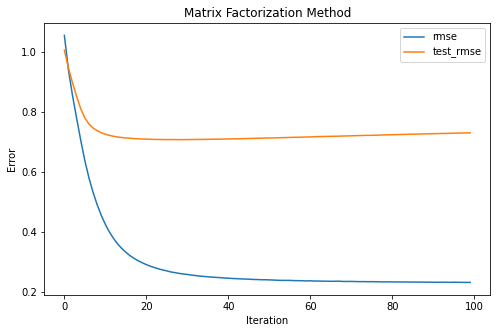

In [365]:
#visualize the training process
plt.figure(figsize=(8,5))
plt.plot(best_history.history['rmse'], label='rmse')
plt.plot(best_history.history['val_rmse'], label='test_rmse')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title("Matrix Factorization Method")
plt.legend()

In [366]:
Y_pred = best_model.predict(users_test,movies_test)
test_loss=np.mean((ratings_test-Y_pred)**2)
print(f'F={best_F}, penalty={best_penalty}, test loss={test_loss}')

F=100, penalty=0.0001, test loss=0.7293138903985336


## 4. Model Comparison

Now we compare the performance of the two collaborative filtering algorithms. Since the item-based model can not measure the mean square errow, we will compare their recommendation lists for performance evaluation, specifically using the precision and recall metrics to examine.

### Recommendation for users

In [397]:
#choose a random user
idx=np.random.randint(0,len(users_all))
test_user=users_all[idx]
original_test_user=userEncoder.inverse_transform([test_user])[0]

user_ratings = data_ratings[data_ratings['userId'] == original_test_user][['userId', 'movieId', 'rating']]
user_ratings['MatrixFactor_prediction'] = best_MFmodel.predict(user_ratings.userId, movieEncoder.fit_transform(user_ratings.movieId))
user_ratings

,userId,movieId,rating,MatrixFactor_prediction
52659,345,779,5.0,3.470915
52692,345,3534,4.5,3.003760
52668,345,1127,3.5,3.085003
52695,345,3801,4.0,3.237909
52654,345,11,2.5,3.615185
...,...,...,...,...
52660,345,838,5.0,2.853195
52700,345,5377,3.5,3.996491
52679,345,2359,5.0,3.438814
52707,345,7121,5.0,2.947897


In [399]:
print("Top 10 movies this user rated")
user_ratings.sort_values(by='rating', ascending=False).merge(data_movies, on='movieId', how='inner', 
                                                            suffixes=['_u', '_m']).head(10)['title']

Top 10 movies this user rated


0                       'Til There Was You (1997)
1    Waking Ned Devine (a.k.a. Waking Ned) (1998)
2                   Affair to Remember, An (1957)
3                            All That Jazz (1979)
4                             12 Angry Men (1957)
5                                     Emma (1996)
6                             'Salem's Lot (2004)
7                                    Alien (1979)
8                            All About Eve (1950)
9                               Adam's Rib (1949)
Name: title, dtype: object

In [413]:
print("Top 10 movies recommended for this user")
rec_ItemBased=ItemBasedCFModel.recommend(test_user)
rec_MatrixFactor=best_MFmodel.recommend(test_user)

rec_ItemBased_title=[data_movies[data_movies.movieId==movie].title for movie in rec_ItemBased]
rec_MatrixFactor_title=[data_movies[data_movies.movieId==movie].title for movie in rec_MatrixFactor]

print("ItemBased Recommendation: ")
for movie in rec_ItemBased_title:
    if len(movie): print(movie.values)

print("\nMatrix Factorization Recommendation: ")
for movie in rec_MatrixFactor_title:
    if len(movie): print(movie.values)

Top 10 movies recommended for this user
ItemBased Recommendation: 
['For Whom the Bell Tolls (1943)']
['Strange Love of Martha Ivers, The (1946)']
['Ruthless People (1986)']
['Foxfire (1996)']
['Some Like It Hot (1959)']
['Inspector General, The (1949)']
['In the Line of Fire (1993)']

Matrix Factorization Recommendation: 
['Halloween: Resurrection (Halloween 8) (2002)']
['Almost Heroes (1998)']
['Lilo & Stitch (2002)']
['Mr. Saturday Night (1992)']
['Monster, The (Mostro, Il) (1994)']
['Hocus Pocus (1993)']
['Lumumba (2000)']


Now we want to compute the precision, recall and F1-score number for these two recommendation algorithms.

In [420]:
prec1, recall1 = ItemBasedCFModel.test(test_dict)
F1_1 = (2*recall1*prec1)/(recall1+prec1)

Iteration 0 testing performance now....
Iteration 100 testing performance now....
Iteration 200 testing performance now....
Iteration 300 testing performance now....
Iteration 400 testing performance now....
Iteration 500 testing performance now....
Iteration 600 testing performance now....
precision=0.15245901639344261	 recall=0.061483538278460925


In [424]:
prec2, recall2 = best_MFmodel.test_performance(train_dict,test_dict)
F1_2 = (2*recall2*prec2)/(recall2+prec2)

Iteration 0 testing performance now....
Iteration 100 testing performance now....
Iteration 200 testing performance now....
Iteration 300 testing performance now....
Iteration 400 testing performance now....
Iteration 500 testing performance now....
Iteration 600 testing performance now....
precision=0.19060955518945634	 recall=0.10636123231521883



In [421]:
print(f"Item-based Model: precision={prec1}, recall={recall1}, F1-score={F1_1}")
print(f"Matrix Factorization Model: precision={prec2}, recall={recall2}, F1-score={F1_2}")

Item-based Model: precision=0.15245901639344261, recall=0.061483538278460925, F1-score=0.08762838028832563
Matrix Factorization Model: precision=0.19060955518945634, recall=0.10636123231521883, F1-score=0.12852323565438613


We can see that the precision, recall and F1-score for the Matrix Factorization model is slightly higher than the Item-based model. This is because the MF model considers both the effect of movies and users and their interactions, thus it is more robust especially for predicting the test set.

## 5. Future Work

Given the limited time (12 hours window), two collaborative filtering algorithms are compared on the MovieLens small dataset (100k). If given more time, we project to finish the following parts to improve this movie recommendation model:

1. Consider K-fold cross validation training to improve the model robustness and further avoid the overfitting scenario
2. Use larger MovieLens dataset (27M) to train the model and predict:
    
    This might require use AWS Sagemaker with EC2 instance. Or we can try using Spark with RDD data and mllib library with ALS (Alternating least squares) optimization method to train the matrix factorization models.

3. Combine the two algorithms and even other content-based filtering methods to make an ensemble method for better prediction.